<HR style="height: 5px; border: 0;"/>
#Duplex formation and secondary structure of $\gamma$-PNA observed by NMR and CD *Supplementary Material*
<HR style="height: 5px; border: 0;"/>
#Content

This file present the program used to determine the melting temperatures $T_m$ of PNA molecules,
from absorbance and CD data extracted acquired on Jasco spectrometer.

The document is in two parts
- [the fitting program itself](#fitting),
- [the results](#results) obtained when applying the program to experimental data provided in another file-set.




This Program are provided under the Licence [CeCILL 2.1](http://www.cecill.info/licences/Licence_CeCILL_V2.1-en.html)

This program HAS NOT been tested intensively, it is believed to do what it is supposed to do, 
Howver, you are welcome to check it on your own data.
- Author : M-A Delsuc (madelsuc@unistra.fr)
- Date : August 2015
- Version : 2.0   (Multiexp and error bars was added from version 1.0, also some modification have been made to make the prgm easier to use )


<HR style="height: 5px; border: 0;"/>
#The program <a name="fitting"></a>

This program is a general fitting program, meant to analyze melting curves, either from Absorption or CD data.
It has been used here to analyze the PNA data presented in the associated work, but can certainly be used on any other data.


It is in three parts :
 - [reading](#reading) the Jasco files
   - This part in independent from the other part, and can be extended to adapt your own set-up,  the main entry point is `load()` .
   - JASCO csv and txt files are programmed
   - the `FrenchCoding` flag allows to access the files on a french version of Windows,
 - defining a theoretical melting curve, used for fitting
   - this is supposed to be general to any copperative melting mechanism
 - The program itself that read files, fit the melting curve and display the results.
 
 The program comes in two versions:
  - [`Monoexp()`](#Monoexp) permits to fit one melting experiment, measured at one given wavelength
  - [`Multiexp()`](#Multiexp) permits to fit several melting experiments, measured at several wavelengthes

In [1]:
#first, set-up the python scene
import sys
import codecs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
Debug = False

# these two lines are optional, uses seaborn nice setup
try:
    import seaborn as sns
    current_palette = sns.color_palette()
except ImportError:
    pass

%matplotlib inline
mpl.rc("figure", figsize=(12, 6))


##utilities to read the Jasco files <a name="reading"></a>
**Remark** Our JASCO system is running on a french version of Windows. Files are coded with the `latin_1` coding, depending on your set-up, you may need to change this parameter if you experiment coding errors while reading the file.

On the french system, decimal numbers are coded with a comma for decimal : `33,2` instead of `33.2`

Finally the `.csv` files on the french system are coded with a semi colon to separate the field, so a line in a CSV file appears as :
    
    1; 33,2; 64,5
instead of

    1, 33.2, 64.5

This is taking care of with the `FrenchCoding` variable set to `True`

In [2]:
# adapt FileCoding to the ASCII coding used in the JASCO text files
# exemples are
# "cp1252" (Western Europe)   "latin_1" (France and other)   "shift_jis" (japanese)    "utf_8" ...
# check https://docs.python.org/2.7/library/codecs.html#standard-encodings
#FileCoding = "utf_8"
FileCoding = "latin_1"

# set to FrenchCoding to False if you the cvs and txt files are not using the french coding
# (, for decimal point and ; for field separator )
#FrenchCoding = False
FrenchCoding = True

#read files
def loadcsv(fich):
    """
    reads a csv jasco file
    returns data, meta
    where  data as a numpy array 
           meta as a dictionary key:value
    """
    data = []
    meta = {}
    xydata = False
    for lin in codecs.open(fich, "rb", FileCoding):  # the codec may be different on your set-up
        if FrenchCoding:
            lin = lin.replace(',','.')
            linspl = lin.strip().split(';')
        else:
            linspl = lin.strip().split(',')
        if linspl == ['']:       # marks end of data
            xydata = False
        if xydata:               # reading data
            flin = [ float(i) for i in linspl]
            data.append(flin)
        elif len(linspl) >1 :     # ou pas   un champs a recuperer
            meta[linspl[0]] = ";".join(linspl[1:])
        if linspl == ["XYDATA"]:   # marks beginning of data
            xydata = True
    return np.array(data), meta

def loadtxt(fich):
    """
    reads a text jasco file
    returns data, meta
    where  data as a numpy array 
           meta as a dictionary key:value
    """
    data = []
    meta = {}
    xydata = False
    for lin in codecs.open(fich, "rb", FileCoding): # codec may vary
        if FrenchCoding:
            lin = lin.replace(',','.')   # This is for french coding on windows !
        lin = lin.strip()
        linspl = lin.split('\t')
        if linspl == ['']:       # marks end of data
            xydata = False
        if xydata:               # read data
            flin = [ float(i) for i in linspl]
            data.append(flin)
        elif len(linspl) >1 :     #  if meta
            meta[linspl[0]] = "\t".join(linspl[1:])
        if linspl == ["XYDATA"]:   # marks beginning of data
            xydata = True
    return np.array(data), meta

def load(fich):
    "read jasco file, txt or csv based on extension .csv"
    try:
        if fich.endswith(".csv"):
            return loadcsv(fich)
        else:
            return loadtxt(fich)
    except:  # generic error message.
        if FrenchCoding:
            decimal = ","
        else:
            decimal = "."
        print """
        The data file could not be read
        please check
        - file name : %s
        - file coding : %s
        - decimal coding : %s
        """%(fich, FileCoding, decimal)
        sys.exit()

def decoupe(d):
    "extract columns from data array"
    ldo = d[:,0]
    cd = d[:,1]
    volt = d[:,2]
    absorb = d[:,3]
    return (ldo, cd, volt, absorb)
    
def readvalues(fich, tampon=None, lincor=False):
    """
    read file and return cd and abs
    if tampon is a file, will corrected for buffer
    if lincor is True, a linear component is removed
    returns lambda_array, absorb_array, cd_array, remark_text
    """
    d,meta = load(fich)
#    print meta['Comment']
    (ldo, cd, volt, absorb) = decoupe(d)
    if tampon:
        dtamp,metatamp = load(tampon)
        (a, b ,c , absorb_tamp) = decoupe(dtamp)
        absorb = absorb-absorb_tamp
        rem = " - corrected"
    else:
        rem = ""
    if lincor:      #eventually correct for linear component evaluated on first points
        zone = int(0.1*len(ldo))
        fit = np.polyfit(ldo[0:zone], absorb[0:zone], 1)
        absorb = absorb-np.polyval(fit, ldo)
    return ldo, absorb, cd, rem

def plotcd(fich, tampon=None, lincor=False, label=None):
    "draws cd from file:fich with label,  with eventual corrections"
    ldo, absorb, cd, rem = readvalues(fich, tampon=tampon, lincor=lincor)
    if label is None:
        label = fich+rem
    plt.plot(ldo, cd, label=label)
    plt.legend()
    plt.title(fich)

def plotabs(fich, tampon=None, lincor=False, label=None):
    "draws absorbance from file:fich with label,  with eventual corrections"
    ldo, absorb, cd, rem = readvalues(fich, tampon=tampon, lincor=lincor)
    if label is None:
        label = fich+rem
    plt.plot(ldo, absorb, label=label)
    plt.legend()
    plt.title(fich)

##melting curve definition,
used for fitting, implements the hypoerbolic-tangent model,
see for instance :
M. YA. AZBEL, "DNA sequencing and melting curve" *P.N.A.S.*  **76** (1) pp.101-105 (1979)



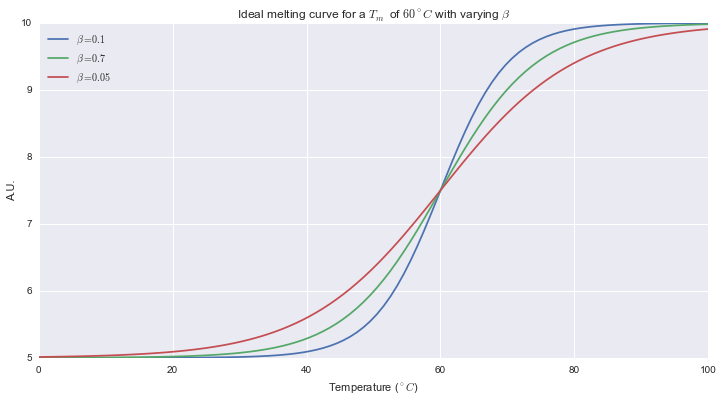

In [3]:
#T_m fitter
def Tmfunc(T, Io, Ie, Tm, beta):
    """
    draw a theoretical fusion curve 
    T: temperature range
    Io Ie : value at low and high temp
    Tm: fusion temperature
    beta: cooperativity parameter, proportional to the inverse of the temperature range over which melting develops
    """
    if Debug:
        print "T",T,"\n args",(Io, Ie, Tm, beta)
    tred =   beta*(T-Tm)
    return Io + 0.5*(Ie-Io)*(1+np.tanh(tred))
#and plot theoretical curve
x = np.linspace(0,100,100)
plt.plot(x, Tmfunc(x, 5,10,60,0.1), label=r"$\beta=0.1$")
plt.plot(x, Tmfunc(x, 5,10,60,0.07),label=r"$\beta=0.7$" )
plt.plot(x, Tmfunc(x, 5,10,60,0.05), label=r"$\beta=0.05$" )
plt.xlabel("Temperature ($^\circ C$)")
plt.ylabel("A.U.")
plt.legend(loc=0)
l = plt.title(r"Ideal melting curve for a $T_m$ of $60^\circ C$ with varying $\beta$")

##  the fitting program <a name="Monoexp"></a>
The class `Monoexp()` defines an object which loads the various data of a temperature run followed by CD/Absorbance at one wavelength.

To use, initialize the various attributes (parameters) (check `__init__` for documentation),
attributes are :
- BASE :  the base directory which holds the files
- fnom :  the generic name for the file
- freq : the frequency (wavelength) on wich to apply the measure
- cell : the cell to follow
- tampon : None, or the cell of the buffer
- meth : meth is either "ABS" or "CD"
- nom : used for label in plots
- extension : ".txt" or ".csv"


then use either :
 - `plot()` : plots the curve
 - `analyze()` : plot and fit melting curve, determines $T_m$ and $\beta$

In [4]:
##### Create the programs that compute and display results
class Monoexp(object):
    """
    This class defines an object which loads the various data which describe one experiment
    of a temperature run followed at one wavelength by CD/Absorbance.

    To use,
     - initialize the various parameters (check `__init__()` function for detailled documentation),
    then use either :
     - plot() : plots the curve
     - analyze() : plot and fit melting curve
     """
    def __init__(self):
        """
        creates the object
        The file name will be built from these parameters with self.full()
        """
        self.BASE = "./"         # the base directory which holds the files
        self.fnom = "filename-"  # the generic name for the file
        self.freq = 217          # the frequency to measure
        self.cell = 2            # the cell to follow
        self.tampon = None       # None, or the cell of the buffer
        self.meth = "abs"        # meth is either "ABS" or "CD"
        self.nom = None          # used for label in plots
        self.extension = ".txt"  # ".txt" or ".csv"

    def ls(self):
        "utility to print all possible files, using the name preset"
        import glob
        fn = "%s/%s*%s"%(self.BASE, self.fnom, self.extension)
        print "\n".join( glob.glob(fn) )
    @property
    def full(self):
        "the filename"
        return "%s/%s%dnm-Cell %d%s"%(self.BASE, self.fnom, self.freq, self.cell, self.extension)
    @property
    def tfull(self):
        "the filename of the buffer"
        if self.tampon is not None:
            return "%s/%s%dnm-Cell %d%s"%(self.BASE, self.fnom, self.freq, self.tampon, self.extension)
        else:
            return None
    @property
    def title(self):
        "title for plot"
        if self.meth.lower() == 'cd':
            return 'CD over Temperature'
        elif self.meth.lower() == 'abs':
            return 'Absorbance  over Temperature'
    @property
    def label(self):
        "label for plot"
        if self.nom is None:
            self.nom = self.cell
        return 'PNA %s - $\lambda=%d\,nm$'%( self.nom, self.freq)
    def fit(self, Tm=60.0, beta=0.1, Io=None, Ie=None):
        """
        fit and plot result, initial estimate can be given to help the fit
        
        uses all current attributes (see __init__) to determine which dataset is to be fitted
        
        results are stored in the self?Results dictionary
        """
        global Debug
        ldo, absorb, cd, rem = readvalues(self.full, tampon=self.tfull)
        self.ldo = ldo
        if self.meth.lower() == "abs":
            y = absorb
        elif self.meth.lower() == "cd":
            y = cd
        # set-up initial fit values
        if Io is None:
            Io = y[0]
        if Ie is None:
            Ie = y[-1]
        try:
            popt, pcov = curve_fit(Tmfunc, ldo, y, p0=[Io, Ie, Tm, beta] ) # fit
        except RuntimeError:
            print self.label, "curve could not be fitted"
            self.Results = None
        else:
            perr = 2*np.sqrt(np.diag(pcov))
            self.Results = {
                'Io':popt[0],
                'Ie':popt[1],
                'Tm':popt[2],
                'beta':popt[3],
                'Tm_errorbar':perr[2],
                'beta_error':perr[3] }# store monofit
            self.residu = y-Tmfunc(ldo, *popt)
            self.norm = np.sqrt(np.sum(self.residu**2))
            if Debug: print pcov
            print "%s  Tm: %.1fC +/- %.2f  beta: %.2f  chi2:%.3f"%(self.label, popt[2], perr[2], popt[3], self.norm)
    def showfit(self):
        "plot the result of the fit"
        try:
            R = self.Results
        except:
            raise Exception("fit is not performed yet")
        if R is not None: # None indicates fit not converged
            plt.plot(self.ldo, Tmfunc(self.ldo, R["Io"], R["Ie"], R["Tm"], R["beta"]), 'k--') # and plot
            mn = min( R["Io"], R["Ie"] )
            mx = max( R["Io"], R["Ie"] )
            if R["Tm"] < 100.0 and R["Tm"] > 0.0:    # do not plot out-of-range results
                plt.plot([R["Tm"],R["Tm"]], [mn,mx], 'k:')

    def plot(self):
        "plot the experimental curve"
        if self.meth.lower() == "abs":
            self.abs()
            plt.ylabel("A.U.")
        elif self.meth.lower() == "cd":
            self.cd()
            plt.ylabel("Ellipticity - millideg")
        plt.legend(loc=0)
        plt.title(self.title)
        plt.xlabel("Temperature ($^\circ C$)")
    def analyze(self, Tm=60.0, beta=0.1, Io=None, Ie=None):
        "fit (using initial guess if provided)  and plot"
        self.plot()
        self.fit(Io=Io, Ie=Ie, Tm=Tm, beta=beta)
        self.showfit()
    def abs(self):
        "read absorbance values"
        ldo, absorb, cd, rem = readvalues(self.full, tampon=self.tfull)
        plt.plot(ldo, absorb, label=self.label)
    def cd(self):
        "read CD values"
        ldo, absorb, cd, rem = readvalues(self.full, tampon=self.tfull)
        plt.plot(ldo, cd, label=self.label)


## second method <a name="Multiexp"></a>
The class `Multiexp()` is very close to `Monoeexp`, the only difference, is that it allows to fit several measures at different wavelength, to the same $T_m$ value

It is to initialize in the same manner than Monoexp,
It has an additional attribute :
 - multifreq : a list of the wavelengths to use in the fitting/plotting operations

then use either :
 - `plot()` : plots the curve
 - `analyze()` : plot and fit all the curves named by multifreq to a same $T_m$

In [5]:
def TmMfunc(T, *args):
    """
    Equivalent to Tmfunc, bur for several wavelengths, using the same Tm and beta
    everything is flattened into 1D arrays (parameters, and return values)
    
    T: temperature range
    N, Io, Ie, Tm, beta = *args
    Tm: fusion temperature
    beta: cooperativity parameter
    N: number of curve to analyze,
    then for each curve
        Io Ie : value at low and high temp
    """
    global Ncurves, Debug  # Ncurves contains the number of curves to fit
    if Debug:
        print "T",T,"\n args",args
    N = Ncurves
    Io = args[0:N]
    Ie = args[N:2*N]
    Tm = args[-2]
    beta = args[-1]
    r = []
    for i in range(len(Io)):
        tred = beta*(T[i]-Tm)
        r.append(Io[i] + 0.5*(Ie[i]-Io[i])*(1+np.tanh(tred)))
    return np.array(r).flatten()
class Multiexp(Monoexp):
    def __init__(self):
        super(Multiexp, self).__init__()
        self.multifreq = []
    def fit(self, Tm=60.0, beta=0.1, Io=None, Ie=None):
        """
        fit and plot result, initial estimate can be given to help the fit
        values are given for initial estimate
        
        uses all current attributes (see __init__) to determine which dataset is to be fitted
        
        results are stored in the self.Results dictionary
        """
        global Ncurves   # Ncurves contains the number of curves to fit
        y = []
        self.ldo = []
        for self.freq in self.multifreq:
            ldo, absorb, cd, rem = readvalues(self.full, tampon=self.tfull)
            self.ldo.append(ldo)
            if self.meth.lower() == "abs":
                y.append(absorb)
            elif self.meth.lower() == "cd":
                y.append(cd)
        # set-up initial fit values
        if Io is None:
            Io = [i[0] for i in y]
        if Ie is None:
            Ie = [i[-1] for i in y]
        y = np.array(y).flatten()
        self.ldo = np.array(self.ldo)
        Ncurves = len(Io)
        p0 = Io + Ie + [Tm] +  [beta] # all parameters are concatenated
        r = (TmMfunc(self.ldo, *p0 ) - y)
        if Debug:
            print self.ldo.shape, y.shape, len(p0)
            print TmMfunc(self.ldo, *p0 ).shape
            print p0
            print r
        try:
            popt, pcov = curve_fit(TmMfunc, self.ldo, y, p0=p0, maxfev = 6000)
        except RuntimeError:
            popt = p0
            perr = None
        else:
            print self.fitlabel, "curve could not be fitted"
            if Debug: print popt
            self.residu = y-TmMfunc(self.ldo, *popt)
            self.norm = np.sqrt(np.sum(self.residu**2))
            perr = 2*np.sqrt(np.diag(pcov))
            print "%s  Tm: %.1fC +/- %.2f   beta: %.2f  chi2:%.3f"%(self.fitlabel, popt[-2], perr[-2], popt[-1], self.norm)
        if Debug:
                print popt
                self.residu = y-TmMfunc(self.ldo, *popt)
                self.norm = np.sqrt(np.sum(self.residu**2))
        if perr is not None:            
            self.Results = {
                'N':Ncurves,
                'Io':popt[0:Ncurves],
                'Ie':popt[Ncurves:2*Ncurves],
                'Tm':popt[-2],
                'beta':popt[-1],
                'Tm_errorbar':perr[-2],
                'beta_error':perr[-1] }# store monofit
        else:
            self.Results = None

    def showfit(self):
        "plot the result of the fit"
        try:
            R = self.Results
        except:
            raise Exception("fit is not performed yet")
        if self.Results is not None:
            for i in range(R['N']):
                plt.plot(self.ldo[i], Tmfunc(self.ldo[i], R["Io"][i], R["Ie"][i], R["Tm"], R["beta"]), 'k--') # and plot
            mn = min( min(R["Io"]), min(R["Ie"]) )
            mx = max( max(R["Io"]), max(R["Ie"]) )
            if R["Tm"] < 100.0 and R["Tm"] > 0.0:    # do not plot out-of-range results
                plt.plot([R["Tm"],R["Tm"]], [mn,mx], 'k:')
    def plot(self):
        for self.freq in self.multifreq:
            super(Multiexp, self).plot()
    @property
    def fitlabel(self):
        "label for fit"
        if self.nom is None:
            self.nom = self.cell
        return 'PNA %s'%( self.nom)


<HR style="height: 5px; border: 0;"/>


#Experimental Results <a name="results"></a>

A directory called `PNA_DATA/` should be available along with this program.
It contains a set of files holding the data acquired on the various PNA studied.

The experiments were acquired on by Absorbance and CD on a Jasco J-815 spectropolarimeter using 1mm path length 110 quartz UV cells.
Each run was performed first by heating, the temperature varying from 308 K to 368 K with a 1 K/mn variation rate, and then by a cooling experiment performed at the same rate.

Each file contains one measure on one PNA, at one wavelength, on a temperature series.
The files are distributed among several folders corresponding to different experimental runs.
The name of the file codes for the sample, the wavelength and the temperature variation (going up or down)



##PNA 2 and 3
melting followed by absorbance and CD
- buffer is in 1
- PNA 2 in 2
- PNA3 in 3

### CD Spectrum
First we plot the CD spectrum :

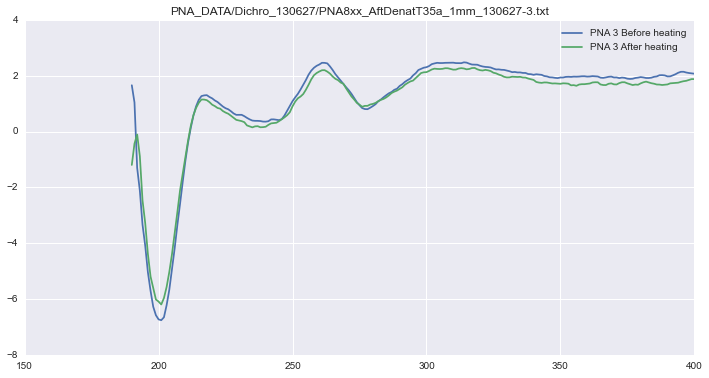

In [6]:
plotcd(fich="PNA_DATA/Dichro_130627/PNA8xx_T35a_1mm_130627-3.txt",
       tampon="PNA_DATA/Dichro_130627/PNA8xx_T35a_1mm_130627-1.txt", lincor=False, label="PNA 3 Before heating")
plotcd(fich="PNA_DATA/Dichro_130627/PNA8xx_AftDenatT35a_1mm_130627-3.txt",
       tampon="PNA_DATA/Dichro_130627/PNA8xx_T35a_1mm_130627-1.txt", lincor=False, label="PNA 3 After heating")


###Temperature variation - going-up
1$^\circ$C / min

The following wave-lengths were recorded : 200nm 217nm 230nm 260nm 310nm 380nm 

Results are shown for **Absorbance** signal, and for **CD** signal for PNA-3 (PNA-2 is non chiral)

Not all frequencies give fittable results.

First we can use `Monoexp()` to fit the best curve.

In [7]:
f = Monoexp() 
f.BASE = "PNA_DATA/Dichro_130627"
f.fnom = "PNA8xx_Denat_130627-1-"
f.ls()

PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-200nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-200nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-200nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-217nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-217nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-217nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-230nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-230nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-230nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-260nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-260nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-260nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-310nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-310nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-310nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Denat_130627-1-380nm-Cell 1.txt
PNA_DATA

###PNA-2 Absorbance

First we fit one wavelength : 200nm

PNA 2 - $\lambda=200\,nm$  Tm: 66.2C +/- 0.94  beta: 0.06  chi2:0.014


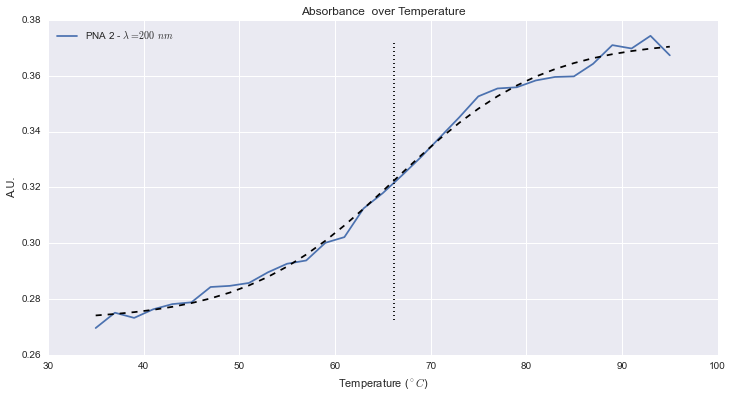

In [8]:
f.tampon = 1
f.cell = 2
f.meth = "ABS"
f.freq = 200       # the 200nm curve give the best results
f.analyze()


Then we try to fit all the curves at once using `Multiexp()`, defined in multifreq

PNA 2 curve could not be fitted
PNA 2  Tm: 66.3C +/- 1.30   beta: 0.06  chi2:0.048


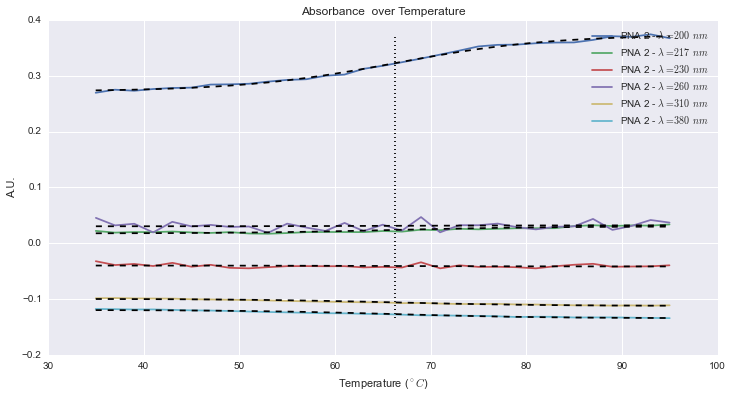

In [9]:
f = Multiexp() 
f.BASE = "PNA_DATA/Dichro_130627"
f.fnom = "PNA8xx_Denat_130627-1-"
f.tampon = 1
f.meth = "ABS"
f.multifreq = (200, 217, 230, 260,310,380)
f.analyze()

As `Multiexp()` gives satisfactory results, we will use it in the following, all curves are plotted, but only the curve giving interpretable results are fitted.

Results are accumulated into a global ordered dictionary, for the final conclusion

In [10]:
import collections 
RESULTS = collections.OrderedDict()
RESULTS["PNA-2 Abs"]=f.Results

###PNA-3 Absorbance

PNA 2 curve could not be fitted
PNA 2  Tm: 71.1C +/- 1.77   beta: 0.04  chi2:0.054


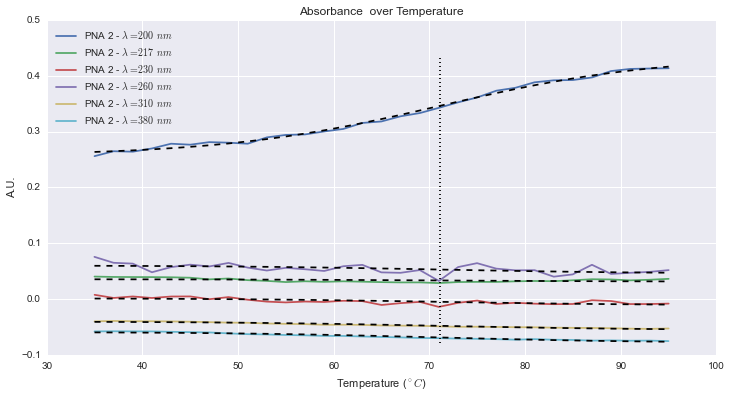

In [11]:
f.cell = 3
f.multifreq = (200, 217, 230, 260,310,380)
f.analyze()
RESULTS["PNA-3 Abs"] = f.Results

###PNA-3 CD

PNA 2 curve could not be fitted
PNA 2  Tm: 68.4C +/- 0.98   beta: 0.06  chi2:1.572


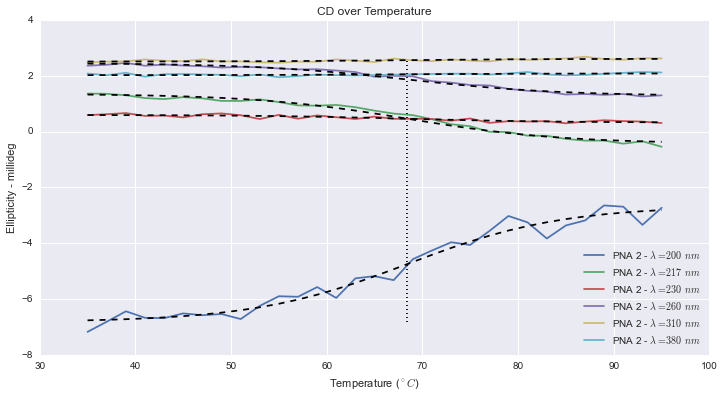

In [12]:
f.meth = "CD"
f.cell = 3
f.multifreq = (200, 217, 230, 260, 310, 380)
f.analyze()
RESULTS["PNA-3 CD"]=f.Results

###Temperature variation, going down 

(1 degree / minute)

following wave-lengthes were recorded : 217nm 260nm 380nm 

In this series, only CD of PNA-3 could be reliably analyzed,
in particular because of the lack of measurements at 200nm, 
wave-length that gave the best results in the previous series.

Nevertheless, some shift in temperature are observed compared to the previous experiment.

In [13]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_130627"
f.fnom = "PNA8xx_Cooling_130627-1-"
f.ls()

PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-217nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-217nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-217nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-260nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-260nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-260nm-Cell 3.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-380nm-Cell 1.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-380nm-Cell 2.txt
PNA_DATA/Dichro_130627/PNA8xx_Cooling_130627-1-380nm-Cell 3.txt


###PNA-2 Absorbance

PNA 2 curve could not be fitted
PNA 2  Tm: 54.3C +/- 36.58   beta: 0.03  chi2:0.030


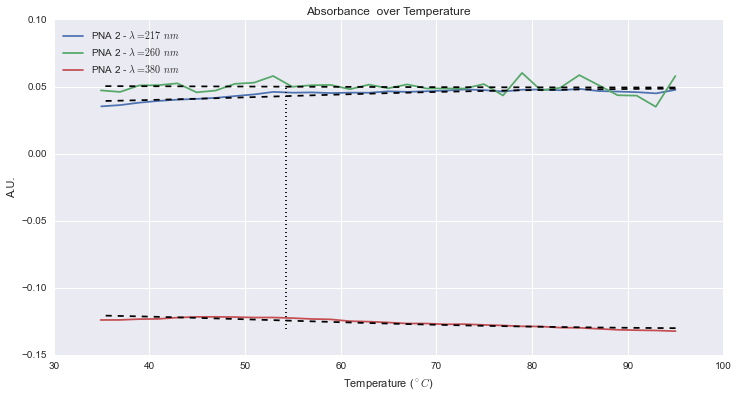

In [14]:
f.meth = "ABS"
f.tampon = 1
f.cell = 2
f.multifreq = (217, 260, 380,)
f.analyze()

###PNA-3 Absorbance

PNA 2 curve could not be fitted
PNA 2  Tm: 73.2C +/- 5.00   beta: 0.11  chi2:0.025


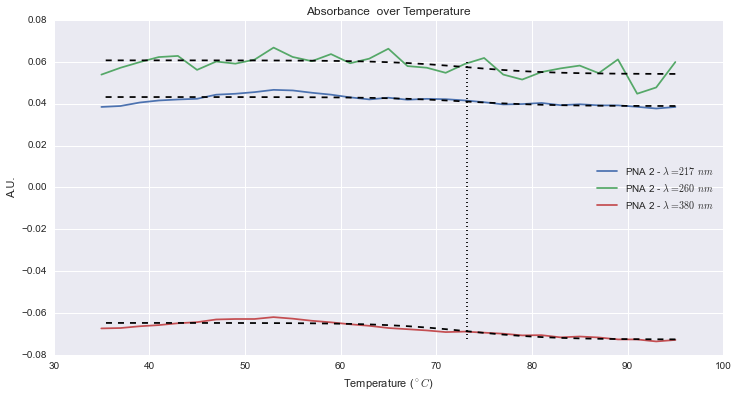

In [15]:
f.meth = "ABS"
f.tampon = 1
f.cell = 3
f.multifreq = (217, 260, 380,)
f.analyze()

###PNA-3 CD

PNA 2 curve could not be fitted
PNA 2  Tm: 68.1C +/- 1.82   beta: 0.06  chi2:0.788


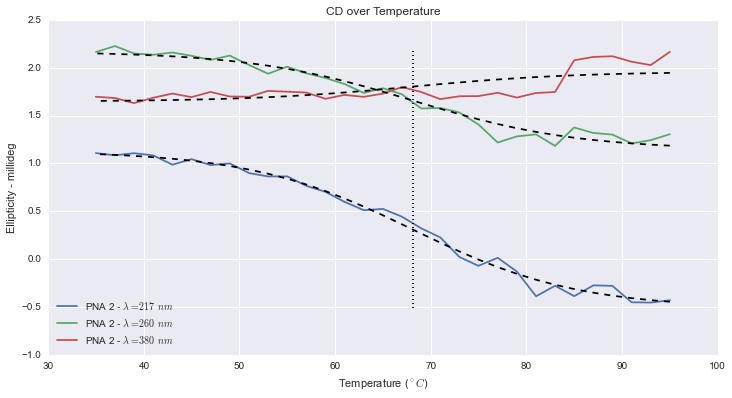

In [16]:
f.meth = "CD"
f.tampon = 1
f.cell = 3
f.multifreq = (217, 260, 380,)
f.analyze()
RESULTS["PNA-3 CD 2"] = f.Results   # results stored as 2 are for decreasing temperatures

##PNA 4 & 6

The same protocole was then applied on the two PNA 4 and 6.
Here PNA-4 is in cell 3, and PNA-6 is in cell 4.

PNA-7 (see below) is in cell 5.

###going up
raison the temperature, 1$^\circ$C / min

measured wavelengths 218 240 262 280 350

In [17]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_130711"
f.fnom = "PNA8xx_Denat_130711-1-"
f.ls()

PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-280nm-Cell 1.txt
PNA_DATA

###PNA-4 Absorbance

PNA 4 curve could not be fitted
PNA 4  Tm: 86.4C +/- 4.18   beta: 0.11  chi2:0.059


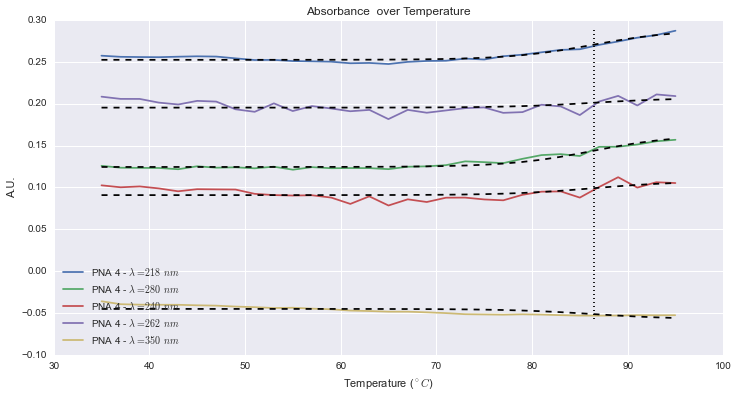

In [18]:
f.meth = "ABS"
f.tampon = 1
f.cell = 3
f.nom = 4
f.multifreq = (218, 280, 240, 262, 350)
f.analyze()
RESULTS["PNA-4 Abs"] = f.Results

###PNA-6 Absorbance

PNA 6 curve could not be fitted
PNA 6  Tm: 88.8C +/- 5.51   beta: 0.09  chi2:0.060


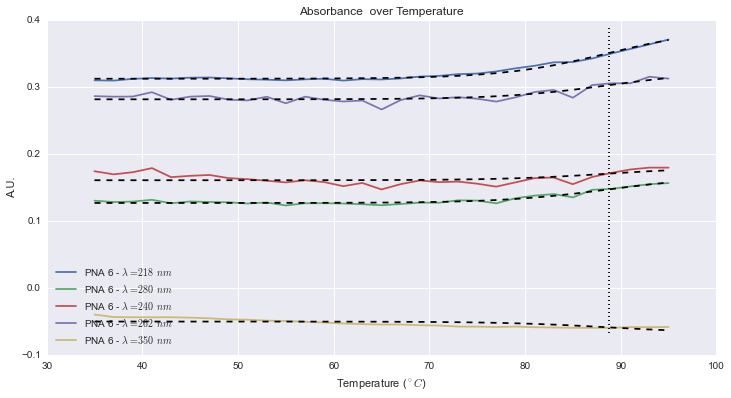

In [19]:
f.cell = 4
f.nom = 6
f.multifreq = (218, 280, 240, 262, 350)
f.analyze()
RESULTS["PNA-6 Abs"] = f.Results

###PNA-4 by CD

PNA 4 curve could not be fitted
PNA 4  Tm: 81.7C +/- 2.43   beta: 0.04  chi2:0.750


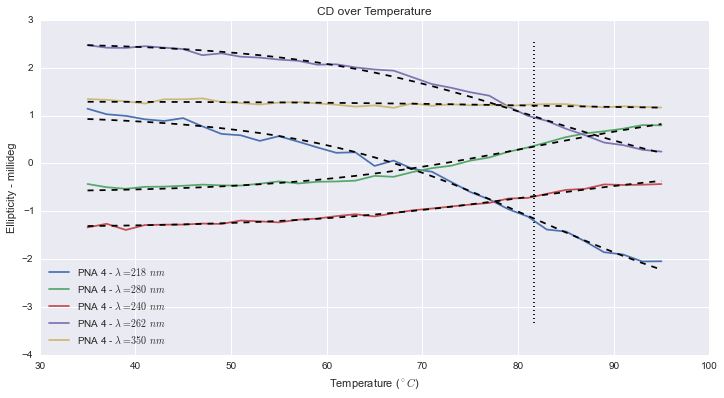

In [20]:
f.meth = "CD"
f.cell = 3
f.nom = 4
f.multifreq = (218, 280, 240, 262, 350)
f.analyze()
RESULTS["PNA-4 CD"] = f.Results

###PNA-6 by CD

PNA 6 curve could not be fitted
PNA 6  Tm: 83.0C +/- 4.50   beta: 0.03  chi2:1.108


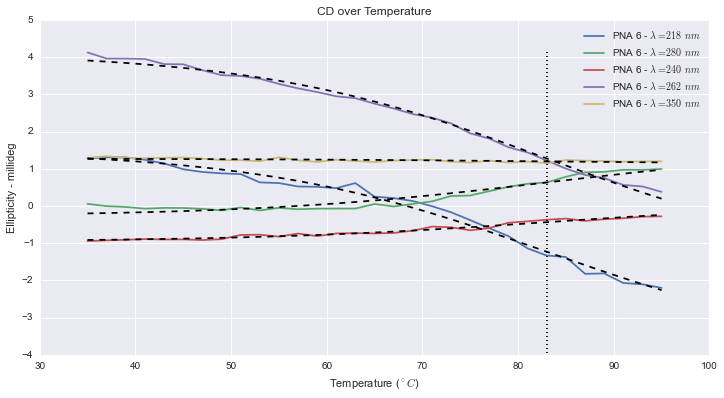

In [21]:
f.cell = 4
f.nom = 6
f.multifreq = (218, 280, 240, 262, 350)
f.analyze()
RESULTS["PNA-6 CD"] = f.Results

###going down
218 240 262 280 350
Abs does not work

In [22]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_130711"
f.fnom = "PNA8xx_Cooling_130711-1-"
f.ls()

PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-218nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-218nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-218nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-218nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-218nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-240nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-240nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-240nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-240nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-240nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-262nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-262nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-262nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-262nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_130711-1-262nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Cooling_13

PNA 4 curve could not be fitted
PNA 4  Tm: 80.2C +/- 1.70   beta: 0.04  chi2:0.731


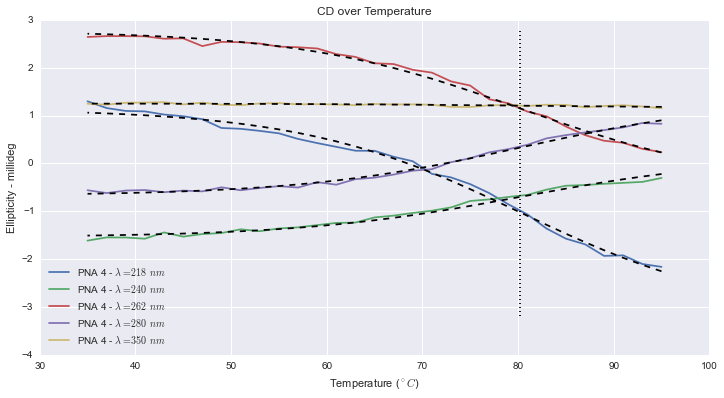

In [23]:
f.meth = "CD"
f.tampon = 1
f.cell = 3
f.nom = 4
f.multifreq = (218, 240, 262, 280, 350)
f.analyze()
RESULTS["PNA-4 CD 2"] = f.Results

PNA 6 curve could not be fitted
PNA 6  Tm: 80.9C +/- 3.60   beta: 0.03  chi2:0.996


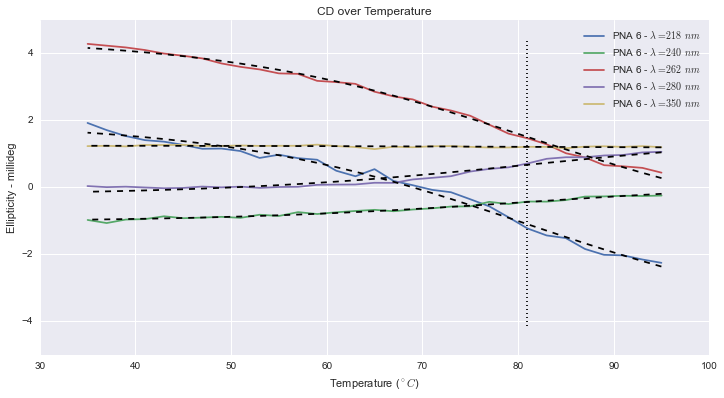

In [24]:
f.meth = "CD"
f.tampon = 1
f.cell = 4
f.nom = 6
f.multifreq = (218, 240, 262, 280, 350)
f.analyze()
RESULTS["PNA-6 CD 2"] = f.Results

##PNA 5

Buffer is in cell 1 and PNA-5 in cell 3

PNA-5 is non-chiral, so CD is irrelevant

wavelengths : 200 207 215 250

In [25]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/"
f.fnom = "PNA_120919_ThermDenat-1-"
f.extension = ".csv"
f.ls()

PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-200nm-cell 1.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-200nm-cell 3.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-207nm-cell 1.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-207nm-cell 3.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-215nm-cell 1.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-215nm-cell 3.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-250nm-cell 1.csv
PNA_DATA/Dichro_PNA5/Abs_Te/ThermalDenat_120919/PNA_120919_ThermDenat-1-250nm-cell 3.csv


PNA 5 curve could not be fitted
PNA 5  Tm: 73.5C +/- 0.54   beta: 0.04  chi2:0.148


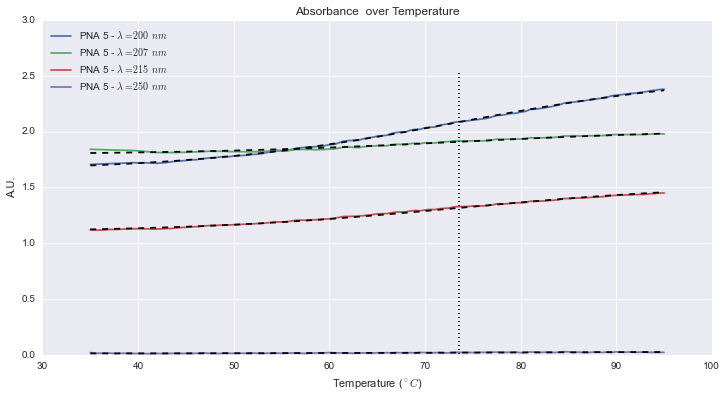

In [26]:
f.meth = "ABS"
f.tampon = 1
f.cell = 3
f.nom = 5
f.multifreq = (200, 207, 215, 250)
f.analyze()
RESULTS["PNA-5 Abs"]=f.Results

PNA 5 curve could not be fitted
PNA 5  Tm: 70.8C +/- 1.77   beta: 0.03  chi2:0.317


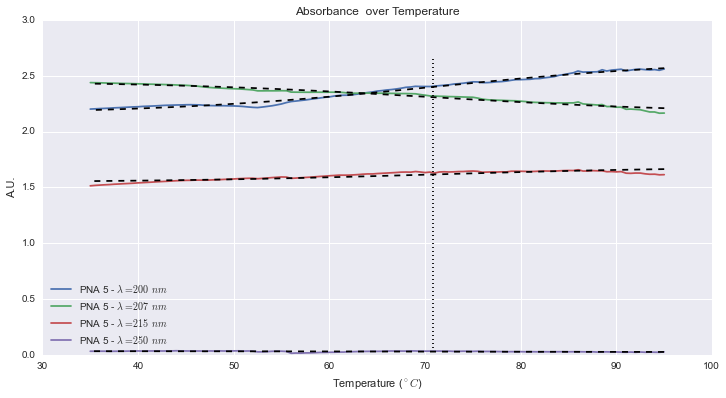

In [27]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_PNA5/Abs_Te/ThermalCooling_120920/"
f.fnom = "PNA_120920_ThermCool-1-"
f.extension = ".csv"
#f.ls()
f.meth = "ABS"
f.tampon = 1
f.cell = 3
f.nom = 5
f.multifreq = (200, 207, 215, 250)
f.analyze()
RESULTS["PNA-5 Abs 2"]=f.Results

##PNA 7
PNA 7 is quite special, it presents a $T_m$ very high, much over than the highest experimental temperature tested.
In consequence, the experimental curves only sample a small portion of the melting curve, and do not permit a precise evaluation of the melting temperature.

It can be seen in the curves, and the results given for the different experiment are not coherent.

PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-218nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-240nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 1.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 2.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 3.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 4.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-262nm-Cell 5.txt
PNA_DATA/Dichro_130711/PNA8xx_Denat_130711-1-280nm-Cell 1.txt
PNA_DATA

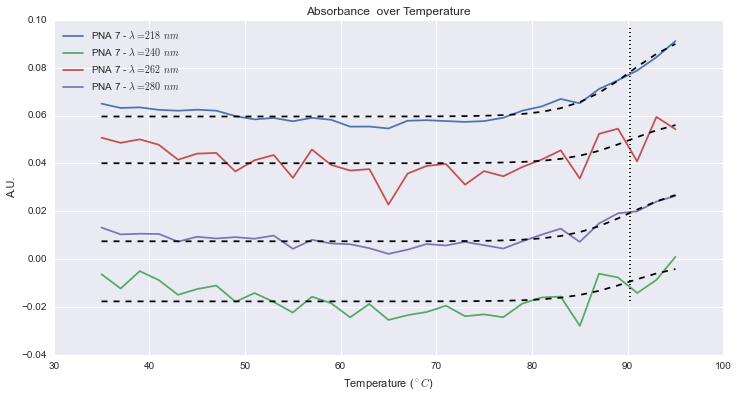

In [28]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_130711"
f.fnom = "PNA8xx_Denat_130711-1-"
f.ls()
f.meth = "ABS"
f.tampon = 1
f.cell = 5
f.nom = 7
f.multifreq = (218,  240, 262, 280) #, 350)
f.analyze()
RESULTS["PNA-7 Abs"]=f.Results

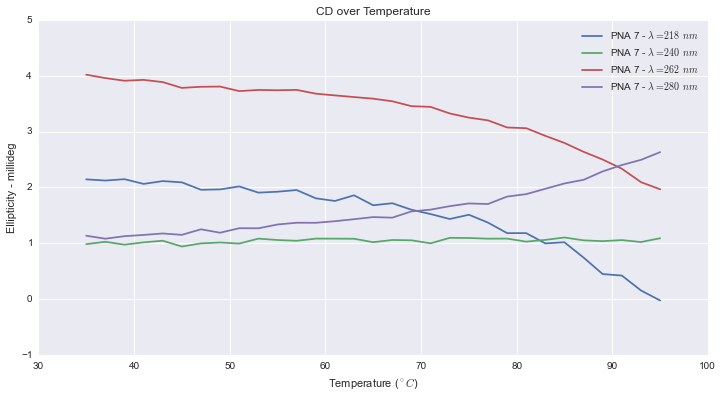

In [29]:
f.meth = "CD"
f.multifreq = (218, 240, 262, 280)
f.analyze(Tm=80.0,beta=0.05)

Here, the program is not able to fit the data, even though the initial values (plotted above) seem pretty good.

Probably the $T_m$ value is very high, and cannot be determined.

PNA 7 curve could not be fitted
PNA 7  Tm: 72.1C +/- 3.24   beta: 0.15  chi2:0.064


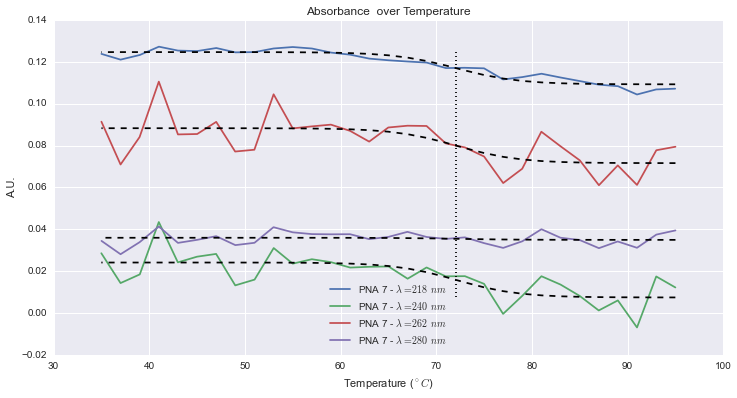

In [30]:
f = Multiexp()
f.BASE = "PNA_DATA/Dichro_130711"
f.fnom = "PNA8xx_Cooling_130711-1-"
#f.ls()
f.meth = "ABS"
f.tampon = 1
f.cell = 5
f.nom = 7
f.multifreq = (218,  240, 262, 280)
f.analyze()
RESULTS["PNA-7 Abs 2"]=f.Results

PNA 7 curve could not be fitted
PNA 7  Tm: 165.5C +/- 149.85   beta: 0.02  chi2:0.501


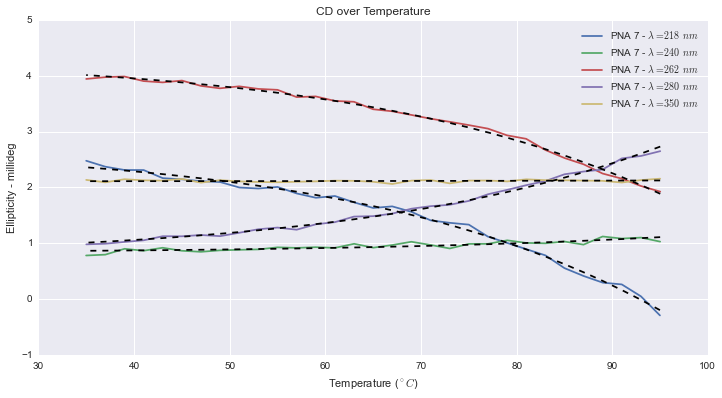

In [31]:
f.meth = "CD"
f.multifreq = (218,  240, 262, 280, 350)
f.analyze()
RESULTS["PNA-7 CD 2"]=f.Results

#conclusion
Results have been accumulated and are given below:

In [32]:
#print RESULTS
for k,v in RESULTS.items():
    print "%s Tm : %.1f +/- %.2f"%(k, v['Tm'], v['Tm_errorbar'])

PNA-2 Abs Tm : 66.3 +/- 1.30
PNA-3 Abs Tm : 71.1 +/- 1.77
PNA-3 CD Tm : 68.4 +/- 0.98
PNA-3 CD 2 Tm : 68.1 +/- 1.82
PNA-4 Abs Tm : 86.4 +/- 4.18
PNA-6 Abs Tm : 88.8 +/- 5.51
PNA-4 CD Tm : 81.7 +/- 2.43
PNA-6 CD Tm : 83.0 +/- 4.50
PNA-4 CD 2 Tm : 80.2 +/- 1.70
PNA-6 CD 2 Tm : 80.9 +/- 3.60
PNA-5 Abs Tm : 73.5 +/- 0.54
PNA-5 Abs 2 Tm : 70.8 +/- 1.77
PNA-7 Abs Tm : 90.2 +/- 5.25
PNA-7 Abs 2 Tm : 72.1 +/- 3.24
PNA-7 CD 2 Tm : 165.5 +/- 149.85
